In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import scipy.stats

import skimage
from skimage import io
import glob

import sklearn
from scipy.ndimage import gaussian_filter

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print(len(all_xray_df))
all_xray_df.sample(3)


112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
10286,00002666_010.png,Infiltration,10,2666,38,M,PA,2048,2500,0.171,0.171,NaN
39046,00010222_011.png,Atelectasis|Edema,11,10222,48,M,AP,2500,2048,0.168,0.168,NaN
94622,00024361_000.png,No Finding,0,24361,45,F,PA,2356,2549,0.143,0.143,NaN


### Data chracterstics
**Image Index** is the File Name. **Follow up #**  is. **View Position** is the orientation in which X-Ray was performed. **Finding Labels** is the disease that was observed in the corrosponding Image. Their is no description of **Unnamed 11** column on the database site, and also I found out that all it's values are NaN, so it is useless and we will drop it.

In [3]:
# note: this cell should be run once and only if "Unnamed: 11" column is present
assert(all_xray_df["Unnamed: 11"].isnull().sum() == len(all_xray_df))
all_xray_df.drop("Unnamed: 11", axis =1, inplace=True)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
52087,00013134_000.png,Pleural_Thickening,0,13134,66,M,PA,2992,2991,0.143,0.143
100378,00026604_002.png,Pneumothorax,2,26604,41,M,AP,3056,2544,0.139,0.139
9652,00002505_022.png,No Finding,22,2505,29,M,PA,2500,2048,0.168,0.168


In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [5]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


The above `all_xray_df.describe()` method is very preliminary analysis tool. Here we can see all the statistical info about numerical data. If we look carefully we can observe some outliers in the Patient's age column. We will take care of those soon.

# EDA

### Distribution of types of classes/diseases.

In [6]:
print(all_xray_df["Finding Labels"].value_counts())
print(len(all_xray_df["Finding Labels"].value_counts()))

No Finding                                                    60361
Infiltration                                                   9547
Atelectasis                                                    4215
Effusion                                                       3955
Nodule                                                         2705
                                                              ...  
Edema|Fibrosis|Infiltration                                       1
Atelectasis|Hernia|Infiltration|Mass|Nodule|Pneumothorax          1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax             1
Effusion|Infiltration|Mass|Pleural_Thickening|Pneumothorax        1
Consolidation|Nodule|Pneumonia                                    1
Name: Finding Labels, Length: 836, dtype: int64
836


As we can see, there are many images in which the diseases occour in combination. Therefore we need to seperate and encode them into different features to obtain some valuable insight. That is, I'm just going to split up my "Finding Labels" column so that **I have one column in my dataframe per disease**, with a binary flag.

In [7]:
# split each value along '|'
x = all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist()
x[:5]

[['Cardiomegaly'],
 ['Cardiomegaly', 'Emphysema'],
 ['Cardiomegaly', 'Effusion'],
 ['No Finding'],
 ['Hernia']]

We will turn the above into list of individual diseases and find the unique diseases out of it. Using itertool's `chain(*iterators)` we can take a series of iterables and returns one iterable. *It groups all the iterables together and produces a single iterable as output*.Its output cannot be used directly and thus explicitly converted into iterables.

In [8]:
x = list(chain(*x))
print(x[:5])
all_labels= np.unique(x)
print(all_labels, len(all_labels))

['Cardiomegaly', 'Cardiomegaly', 'Emphysema', 'Cardiomegaly', 'Effusion']
['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax'] 15


In [9]:
# now we will add these as columns in the database and binary_encode them for images
# remember we have not changed the dataframe yet
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda findings: 1.0 if label in findings else 0.0)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
92454,00023080_006.png,No Finding,6,23080,47,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61722,00015253_001.png,Atelectasis,1,15253,66,F,PA,2610,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87610,00021647_000.png,No Finding,0,21647,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2583,00000669_000.png,No Finding,0,669,47,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32544,00008511_001.png,No Finding,1,8511,25,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
# this is what it looks like
all_xray_df[all_labels].head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

Atelectasis           10.309490
Cardiomegaly           2.475919
Consolidation          4.162504
Edema                  2.054049
Effusion              11.877453
Emphysema              2.244024
Fibrosis               1.503746
Hernia                 0.202462
Infiltration          17.743489
Mass                   5.156975
No Finding            53.836068
Nodule                 5.646629
Pleural_Thickening     3.019087
Pneumonia              1.276311
Pneumothorax           4.728862
dtype: float64



[Text(0, 0.5, 'No. of images with label')]

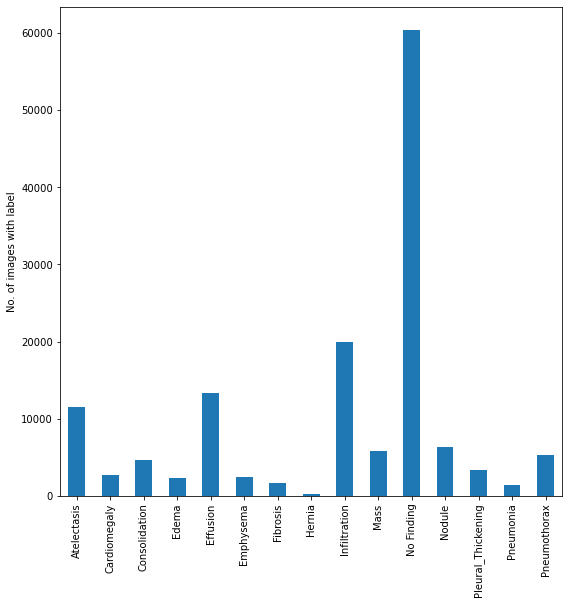

In [11]:
# this is the distribution of diseases
print(all_xray_df[all_labels].sum())
print()
print(all_xray_df[all_labels].sum()/len(all_xray_df)*100)
print()
ax = all_xray_df[all_labels].sum().plot(kind = 'bar', figsize=(9,9))
ax.set(ylabel = 'No. of images with label')

We can see that there are only **1431 cases of Pneumonia out of 112120** i.e. **11069 non-Pneumonia(including No-Finding)** cases.
This tells us that **Pneunomia is rare(1.27%)** generally. But if initial diagnosis results in some problem(i.e. some finding) then then chances **increases to 2.76%**. *Infiltration, Effusion, Atelectasis, Nodules, Masses* are most common findings.

### Distribution of findings co-morbid with Pneumonia.

As we saw in the original dataset, in many images more than one findings were present(No Finding class occours alone). We will now try to analyse the diseases occouring with Pneumonia. 

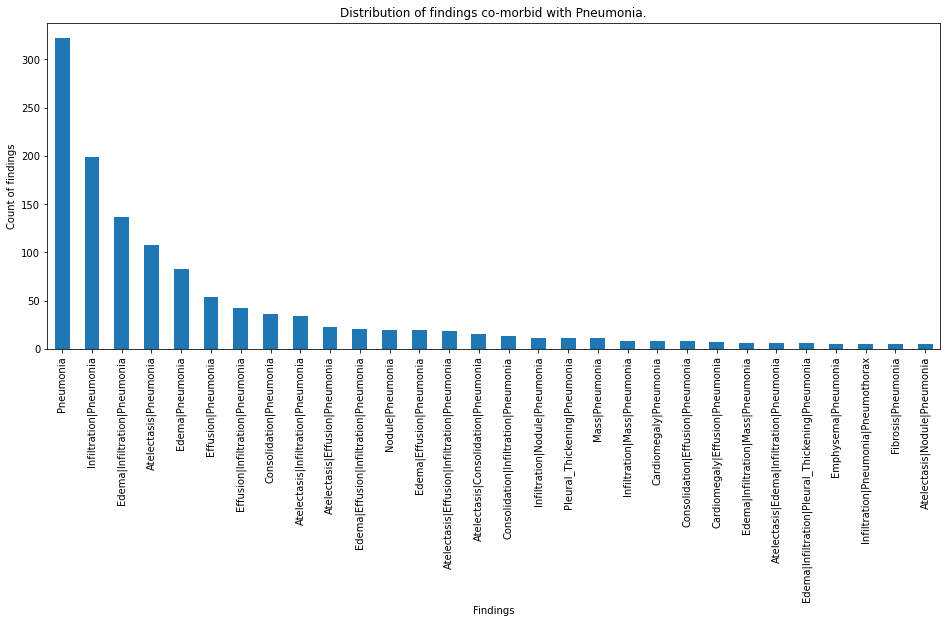

In [12]:
# top 30 diseases occouring with Pneunomia
plt.figure(figsize=(16,6))
plt.xlabel('Findings')
plt.ylabel('Count of findings')
plt.title('Distribution of findings co-morbid with Pneumonia.')
all_xray_df[all_xray_df['Pneumonia'] == 1.0]['Finding Labels'].value_counts()[:30].plot(kind='bar')
plt.show()

**Infiltration, Edema, Atelectasis & Effusion** are some of the most co-morbid(co-occouring) findings with Pneumonia. 

### Patient Demographics

#### How is the data distributed according to Patient's age?

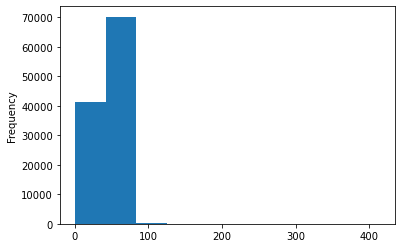

In [13]:
# initial view
all_xray_df['Patient Age'].plot(kind = 'hist')

The data looks extremely positively skewed. After confirming from the above `all_xray_df.describe()` result. We can say that the data has outliers(as max age > 140 is impossible). We will do something to remove these outliers. 

In [14]:
print(len(all_xray_df[all_xray_df['Patient Age'] > 140]))
all_xray_df[all_xray_df['Patient Age'] > 140]

16


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


As we can see there are 16 people with age > 140. It's better for out model if we remove these outliers.

In [15]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 90]
print(len(all_xray_df))

112069


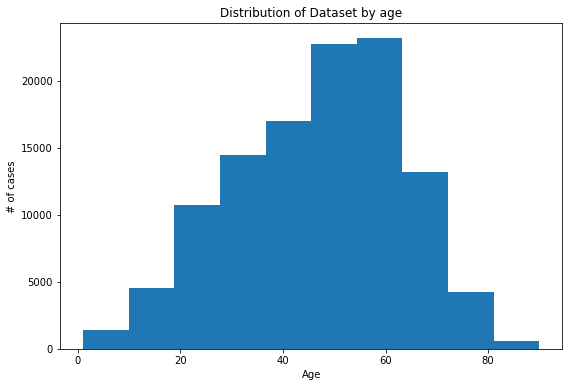

In [16]:
all_xray_df['Patient Age'].plot(kind = 'hist', figsize =(9,6))
plt.title("Distribution of Dataset by age")
plt.xlabel("Age")
plt.ylabel("# of cases")
plt.show()

Now we have a better look at how age is distributed in our dataset. This looks like a **normal distribution**.The **mean and median age is 47 and 49 years** respectively. We can also **look at the age distribution of patients with Pneumonia**.

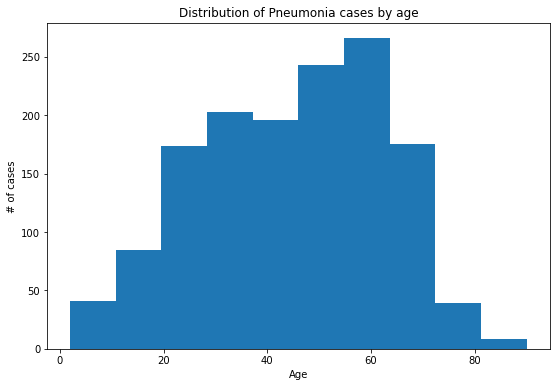

44.67062937062937
46.0
17.639097629242386


In [17]:
all_xray_df[all_xray_df["Pneumonia"] == 1.0]["Patient Age"].plot(kind = 'hist', figsize=(9,6))
plt.title("Distribution of Pneumonia cases by age")
plt.xlabel("Age")
plt.ylabel("# of cases")
plt.show()
print(all_xray_df[all_xray_df["Pneumonia"] == 1.0]["Patient Age"].mean())
print(all_xray_df[all_xray_df["Pneumonia"] == 1.0]["Patient Age"].median())
print(all_xray_df[all_xray_df["Pneumonia"] == 1.0]["Patient Age"].std())

As we can see, the age distribution of Pneumonia cases is vary similar to that of whole database with **44.6 and 46 as mean and median ages** respectively. The patients with age greater than 80 are very few,  Therefore we have to state that our algorithm is best for people aging between 20-70.

#### How is the data distributed according to Patient's Gender?

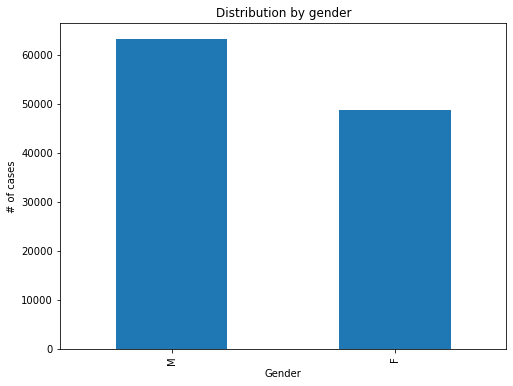

M    63301
F    48768
Name: Patient Gender, dtype: int64


In [18]:
all_xray_df['Patient Gender'].value_counts().plot(kind = 'bar', figsize = (8,6))
plt.title("Distribution by gender")
plt.xlabel("Gender")
plt.ylabel("# of cases")
plt.show()
print(all_xray_df['Patient Gender'].value_counts())

This is the distribution of whole data w.r.t. gender. Now we will look at the distribution of cases with finding as Pneumonia.

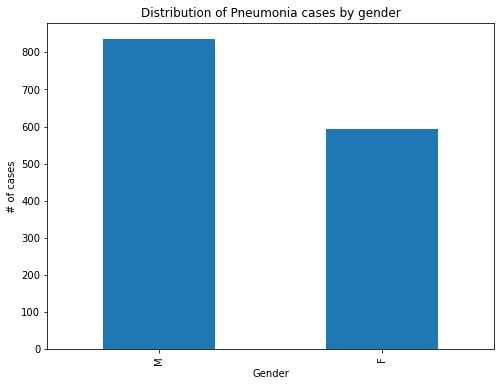

M    837
F    593
Name: Patient Gender, dtype: int64


In [19]:
all_xray_df[all_xray_df["Pneumonia"] == 1.0]['Patient Gender'].value_counts().plot(kind = 'bar', figsize = (8,6))
plt.title("Distribution of Pneumonia cases by gender")
plt.xlabel("Gender")
plt.ylabel("# of cases")
plt.show()
print(all_xray_df[all_xray_df["Pneumonia"] == 1.0]['Patient Gender'].value_counts())

Male dominant dataset.

#### How is the data distributed according to Xray orientation (view position)?

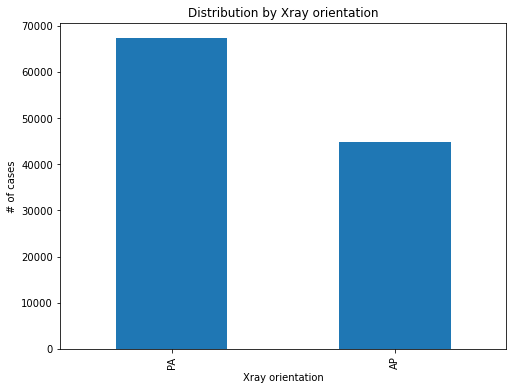

PA    67277
AP    44792
Name: View Position, dtype: int64


In [20]:
all_xray_df['View Position'].value_counts().plot(kind = 'bar', figsize = (8,6))
plt.title("Distribution by Xray orientation")
plt.xlabel("Xray orientation")
plt.ylabel("# of cases")
plt.show()
print(all_xray_df['View Position'].value_counts())

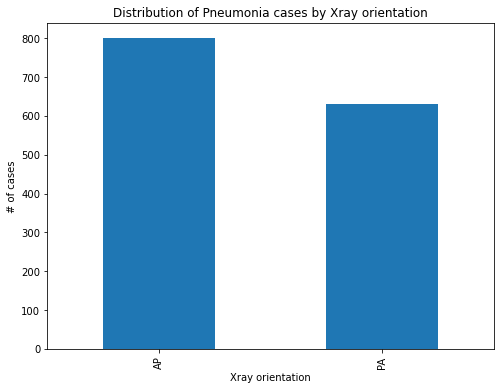

AP    800
PA    630
Name: View Position, dtype: int64


In [21]:
all_xray_df[all_xray_df["Pneumonia"] == 1.0]['View Position'].value_counts().plot(kind = 'bar', figsize = (8,6))
plt.title("Distribution of Pneumonia cases by Xray orientation")
plt.xlabel("Xray orientation")
plt.ylabel("# of cases")
plt.show()
print(all_xray_df[all_xray_df["Pneumonia"] == 1.0]['View Position'].value_counts())

AP view is dominant in both the distributions.AP view is used when a patient is bed ridden and is generally of lower detail tha PA view. To learn more about it watch this(https://www.youtube.com/watch?v=bSspWS96Y9Y).

#### Number of diseases per patient

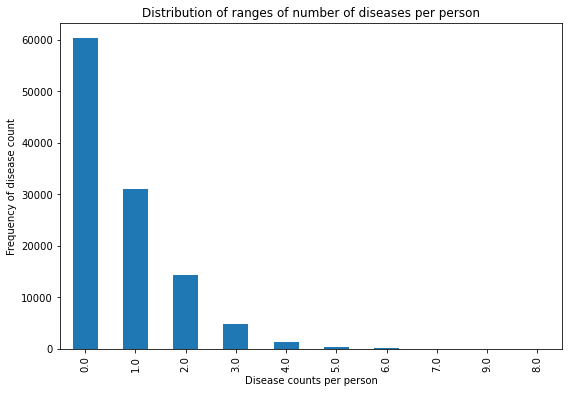

0.0    60332
1.0    30952
2.0    14298
3.0     4855
4.0     1245
5.0      301
6.0       67
7.0       16
9.0        2
8.0        1
dtype: int64

Average Disease count: 0.7240003926152638


In [22]:
disease_labels = list(all_labels)
disease_labels = disease_labels[:10] + disease_labels[11:]
disease_counts = all_xray_df[disease_labels].sum(axis = 1) ## column wise sum
disease_counts.value_counts().plot(kind= 'bar', figsize= (9,6))
plt.title("Distribution of ranges of number of diseases per person")
plt.xlabel("Disease counts per person")
plt.ylabel("Frequency of disease count")
plt.show()
print(disease_counts.value_counts())
print("\nAverage Disease count:",np.mean(disease_counts))

## Pixel-level assessments of the imaging data

In [37]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [38]:
# adding path column as described in training_data.ipynb
all_image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3546,00017541_025.png,Effusion|Infiltration,25,17541,053Y,M,AP,2500,2048,0.168,0.168,/data/images_008/images/00017541_025.png
3855,00018997_001.png,No Finding,1,18997,057Y,F,AP,2500,2048,0.168,0.168,/data/images_009/images/00018997_001.png
682,00003523_012.png,Infiltration,12,3523,023Y,F,AP,2500,2048,0.168,0.168,/data/images_002/images/00003523_012.png


To keep the process simple, we will look at images seperated as Pneumonia and non pneumonia.

In [39]:
sample_df["IsPneumonia"] = sample_df["Finding Labels"].map(lambda finding: 1.0 if "Pneumonia" in finding else 0.0)
print(sample_df['IsPneumonia'].sum())
# see some of the images with their labels and IsPnemonia value.
sample_df.sample(10).loc[:, ['Finding Labels', 'IsPneumonia']]

62.0


,Finding Labels,IsPneumonia
1169,No Finding,0.0
3618,Infiltration,0.0
3943,Atelectasis|Nodule,0.0
4643,No Finding,0.0
5534,Consolidation,0.0
2221,No Finding,0.0
4544,Effusion|Infiltration,0.0
644,No Finding,0.0
1862,No Finding,0.0
3549,No Finding,0.0


In [40]:
pn_sample_df = sample_df[sample_df['IsPneumonia'] == 1.0]
print(pn_sample_df.shape)
pn_sample_df.iloc[:, [1, -1]].sample(5)

(62, 13)


,Finding Labels,IsPneumonia
2875,Pneumonia,1.0
2286,Pneumonia,1.0
4477,Pleural_Thickening|Pneumonia,1.0
4581,Atelectasis|Pneumonia,1.0
3403,Infiltration|Pneumonia,1.0


As we can see, there are **62 images of 5606** images that have *Pneumonia* as a finding(including Pneumonia with other findings). Let's see how these images look.

8


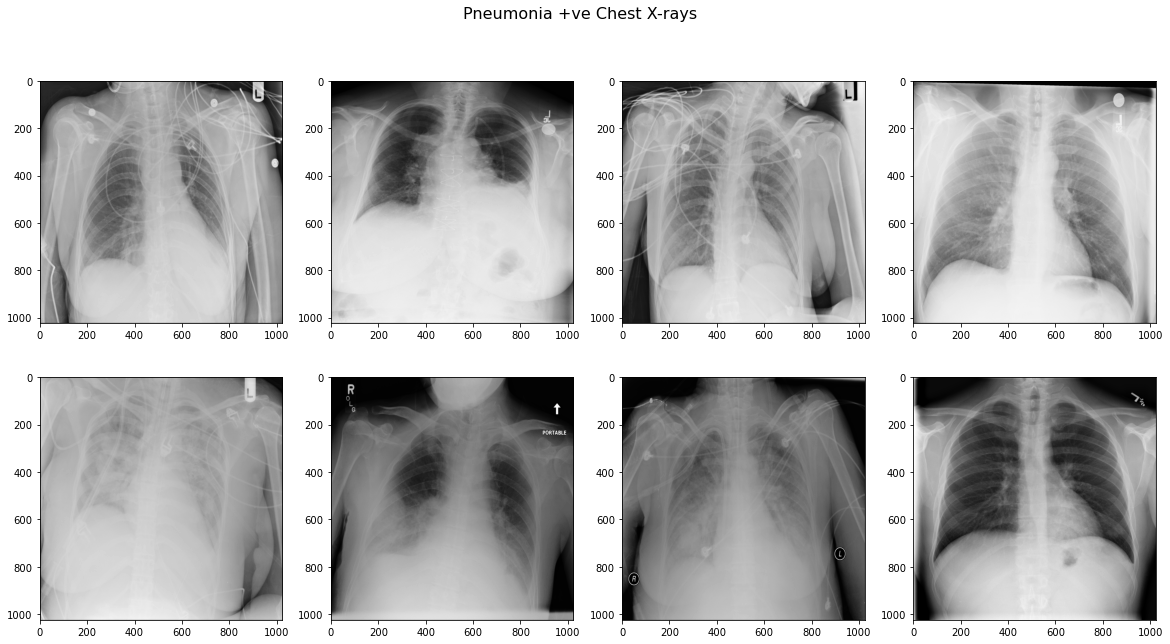

In [41]:
pn_images = list(pn_sample_df.iloc[8:16, -2]) #pick 8 images

## plot
fig, m_axs = plt.subplots(2,4, figsize = (20, 10))
m_axs = m_axs.flatten()
print(len(m_axs))
fig.suptitle('Pneumonia +ve Chest X-rays', fontsize=16)
for i in range(len(pn_images)):
    img = io.imread(pn_images[i])
    m_axs[i].imshow(img, cmap = 'gray')

Store the **intensity distributions** of each of 62 positive images and take their average. This is the **mean intensity distribution** of images with Pneumonia as finding.

In [42]:
ravels = []
for each in pn_sample_df['path']:
    img = io.imread(each)
    image_intensity = img.ravel()
    if len(image_intensity) > 1048576:
        continue
    ravels.append(img.ravel())
    
ravels = np.array(ravels)
mean_intensity_pneunomia = np.mean(ravels, axis = 0) # rowwise
print(len(mean_intensity_pneunomia), np.mean(mean_intensity_pneunomia))

1048576 124.39149643944909


We will find mean intensity distribution for images with **No findings**, ie. healthy images. The mean will be calculated over **62 random No findings** images to be compared with that of Images with Pneumonia.

In [53]:
# extracting data
nf_sample_df = sample_df[sample_df['Finding Labels'] == 'No Finding'].sample(62)
nf_sample_df.iloc[:, [1, -1]].sample(5)

,Finding Labels,IsPneumonia
236,No Finding,0.0
2012,No Finding,0.0
515,No Finding,0.0
1175,No Finding,0.0
3600,No Finding,0.0


Let's see how these images look.

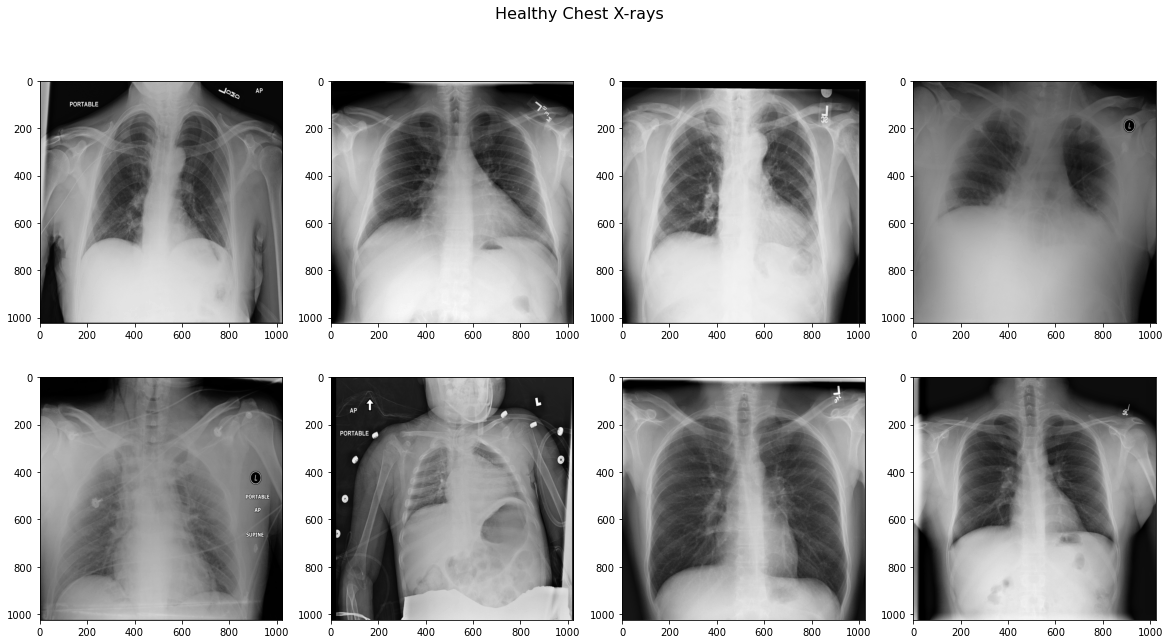

In [54]:
nf_images = list(nf_sample_df.iloc[32:40, -2]) #pick 8 image paths from no finding database.

## plot
fig, m_axs = plt.subplots(2,4, figsize = (20, 10))
m_axs = m_axs.flatten()

fig.suptitle('Healthy Chest X-rays', fontsize=16)
for i in range(len(nf_images)):
    img = io.imread(nf_images[i])
    m_axs[i].imshow(img, cmap = 'gray')

We are already able to observe that chest x-rays of patients with Pneumonia appear more dense(white) than the healthy wones in general. Let's see if this is reflected by their intensity distributions.

In [55]:
# store the intensity distributions of each of 62 positive images and take their average.
nravels = []
for each in nf_sample_df['path']:
    img = io.imread(each)
    image_intensity = img.ravel()
    if len(image_intensity) > 1048576:
        continue
    nravels.append(img.ravel())
    
nravels = np.array(nravels)
mean_intensity_nofindings = np.mean(nravels, axis = 0) # rowwise 
print(len(mean_intensity_nofindings), np.mean(mean_intensity_nofindings))

1048576 125.53756098593438


### Comparision

In [56]:
print(np.mean(mean_intensity_pneunomia), np.mean(mean_intensity_nofindings))

124.39149643944909 125.53756098593438


As we can see,  there is a not much of a difference in the mean values of both the distributions.
Now let's **visualize 1-1 images of both Patients with Pneumonia and No finding** and **compare the distributions** we have obtained.

In [ ]:
fig, m_axs = plt.subplots(2,2, figsize = (16, 12))
m_axs = m_axs.flatten()

# image of person with Pneumonia
img1 = io.imread(pn_sample_df.iloc[24, -2])
m_axs[0].imshow(img1, cmap = 'gray')

#image of healthy person's chest x ray
img2 = io.imread(nf_sample_df.iloc[24, -2])
m_axs[1].imshow(img2, cmap = 'gray')

#plotting mean_intensity_distribution of patients with Pneumonia
m_axs[2].hist(mean_intensity_pneunomia, bins = 256)
m_axs[2].set_xlabel("pixel intensity")
m_axs[2].set_ylabel("# of pixels")
m_axs[2].set_title('Mean_intensity_distribution of Pneumonia Images')

#plotting mean_intensity_distribution of patients with Pneumonia
m_axs[3].hist(mean_intensity_nofindings, bins = 256)
m_axs[3].set_xlabel("pixel intensity")
m_axs[3].set_ylabel("# of pixels")
m_axs[3].set_title('Mean_intensity_distribution of Healthy Images')

Text(0.5, 1.0, 'Mean_intensity_distribution of Healthy Images')

We can conclude that **number of pixels with intensity ranging from 90 to 130 are more in Images with Pneumonia**. So to say that Pneumonia has more of a consistant peak in intensity values. This supports the initial statement that in general, Images with pnumonia appear more dense than ones without Pneumonia.

Let's compare the modes of the distribution.

In [34]:
mode_pn = scipy.stats.mode(mean_intensity_pneunomia)
mode_nf = scipy.stats.mode(mean_intensity_nofindings)
print(mode_pn[0][0], mode_nf[0][0])

125.78688524590164 138.45901639344262


We can try to classify images on the basis of distance from mode.

In [35]:
thresh = 25 # to eleminate unwanted peaks at low intensities produced by the background pixels 
for img_path in pn_images:
    i = io.imread(img_path)
    img_mask = (i > thresh)
    img_mode = scipy.stats.mode(i[img_mask])[0][0]
    pn_delta = np.abs(img_mode - mode_pn[0][0])
    nf_delta = np.abs(img_mode - mode_nf[0][0])
    
    if(pn_delta < nf_delta):
        print("Positive")
    else:
        print("Negative")

Negative
Negative
Negative
Negative
Negative
Positive
Positive
Negative


In [36]:
thresh = 25 # to eleminate unwanted peaks at low intensities produced by the background pixels 
for img_path in nf_images:
    i = io.imread(img_path)
    img_mask = (i > thresh)
    img_mode = scipy.stats.mode(i[img_mask])[0][0]
    pn_delta = np.abs(img_mode - mode_pn[0][0])
    nf_delta = np.abs(img_mode - mode_nf[0][0])
    
    if(pn_delta < nf_delta):
        print("Positive")
    else:
        print("Negative")

Negative
Negative
Negative
Negative
Negative
Negative
Negative
Positive


This Simplestic Outsu's algorithm does not work well in this kind of scanario. We will train and apply state of the art Image classification models.